In [1]:
import duckdb
import pandas as pd
import numpy as np
import missingno as msno
import fonctions as f
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
duckdb.connect()
duckdb.execute("ATTACH DATABASE 'DATA/olist.db' AS olist (TYPE SQLITE);")

In [3]:
df_clients = duckdb.execute("""
WITH
  -- 0) Paiement préféré sur TOUTE la base (mode par customer_unique_id)
  paiement_prefere AS (
    SELECT customer_unique_id, payment_type AS paiement_pref
    FROM (
      SELECT
        c.customer_unique_id,
        p.payment_type,
        COUNT(*) AS cnt,
        ROW_NUMBER() OVER (
          PARTITION BY c.customer_unique_id
          ORDER BY COUNT(*) DESC
        ) AS rn
      FROM olist.order_pymts p
      JOIN olist.orders o
        ON p.order_id = o.order_id
      JOIN olist.customers c
        ON o.customer_id = c.customer_id
      GROUP BY c.customer_unique_id, p.payment_type
    ) t
    WHERE rn = 1
  ),

  -- 1) Comptage global par client pour déterminer 1 vs. >1 commande
  client_stats AS (
    SELECT
      c.customer_unique_id,
      COUNT(*) AS n_cmd
    FROM olist.orders o
    JOIN olist.customers c
      ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
  ),

  -- 2) Tirage aléatoire de 7 000 « nouveaux » et tous les « habitués »
  new_clients AS (
    SELECT customer_unique_id
    FROM client_stats
    WHERE n_cmd = 1
    ORDER BY random()
    LIMIT 7000
  ),
  old_clients AS (
    SELECT customer_unique_id
    FROM client_stats
    WHERE n_cmd > 1
  ),
  sampled_customers AS (
    SELECT customer_unique_id FROM new_clients
    UNION ALL
    SELECT customer_unique_id FROM old_clients
  ),

  -- 3) Pipeline RFM sur ces 10 000 clients
  commandes_base AS (
    SELECT
      c.customer_unique_id,
      o.order_id,
      o.order_purchase_timestamp::TIMESTAMP AS order_date,
      COALESCE(SUM(p.payment_value),0) AS total_paiement,
      COALESCE(AVG(r.review_score),0) AS review_score_cmd
    FROM olist.orders o
    JOIN olist.customers c
      ON o.customer_id = c.customer_id
    LEFT JOIN olist.order_pymts p
      ON o.order_id = p.order_id
    LEFT JOIN olist.order_reviews r
      ON o.order_id = r.order_id
    WHERE c.customer_unique_id IN (SELECT customer_unique_id FROM sampled_customers)
    GROUP BY c.customer_unique_id, o.order_id, o.order_purchase_timestamp
  ),

  -- 4) Écart de jours entre commandes
  deltas_temps AS (
    SELECT
      customer_unique_id,
      order_id,
      date_diff(
        'day',
        LAG(order_date) OVER (PARTITION BY customer_unique_id ORDER BY order_date),
        order_date
      ) AS days_between
    FROM commandes_base
  )

-- 5) Requête finale RFM + paiement préféré
SELECT
  cb.customer_unique_id             AS customer_id,
  c.customer_city                   AS ville,
  c.customer_state                  AS etat,

  /* RFM */
  COUNT(DISTINCT cb.order_id)       AS n_commandes,
  SUM(cb.total_paiement)            AS montant_total,
  AVG(cb.total_paiement)            AS montant_moyen_par_commande,
  AVG(cb.review_score_cmd)          AS satisfaction_moy,

  /* Récence */
  MAX(cb.order_date)                AS date_derniere_cmd,
  date_diff(
    'day',
    MAX(cb.order_date),
    TIMESTAMP '2018-10-17 00:00:00'
  )                                  AS recence,

  /* Fréquence */
  AVG(dt.days_between)              AS temps_moyen_inter_achat,
1.0  / COALESCE(NULLIF(AVG(dt.days_between),0), 1.0) AS freq_par_jour,
7.0  / COALESCE(NULLIF(AVG(dt.days_between),0), 1.0) AS freq_par_semaine,

  /* Paiement préféré sur toute la base */
  pp.paiement_pref,

  /* Autres KPIs */
  COUNT(DISTINCT oi.product_id)     AS nb_produits,
  COUNT(DISTINCT pr.product_category_name) AS n_categories

FROM commandes_base cb
JOIN olist.customers c
  ON cb.customer_unique_id = c.customer_unique_id
LEFT JOIN deltas_temps dt
  ON cb.customer_unique_id = dt.customer_unique_id
 AND cb.order_id        = dt.order_id
LEFT JOIN paiement_prefere pp
  ON cb.customer_unique_id = pp.customer_unique_id
LEFT JOIN olist.order_items oi
  ON cb.order_id = oi.order_id
LEFT JOIN olist.products pr
  ON oi.product_id = pr.product_id

GROUP BY
  cb.customer_unique_id,
  c.customer_city,
  c.customer_state,
  pp.paiement_pref

ORDER BY n_commandes DESC;
""").df()

df_clients.head()

,customer_id,ville,etat,n_commandes,montant_total,montant_moyen_par_commande,satisfaction_moy,date_derniere_cmd,recence,temps_moyen_inter_achat,freq_par_jour,freq_par_semaine,paiement_pref,nb_produits,n_categories
0,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,17,15769.71,54.566471,4.764706,2018-08-20 19:14:26,58,28.875000,0.034632,0.242424,credit_card,15,3
1,3e43e6105506432c953e165fb2acf44c,praia grande,SP,9,17672.22,140.255714,2.642857,2018-02-27 18:36:39,232,19.400000,0.051546,0.360825,credit_card,13,5
2,6469f99c1f9dfae7733b25662e7f1782,santos,SP,7,6811.63,108.121111,5.000000,2018-06-28 00:43:34,111,38.000000,0.026316,0.184211,credit_card,5,1
3,ca77025e7201e3b30c44b472ff346268,recife,PE,7,14885.08,177.203333,5.000000,2018-06-01 11:38:29,138,24.727273,0.040441,0.283088,credit_card,9,4
4,1b6c7548a2a1f9037c1fd3ddfed95f33,ituiutaba,MG,7,9705.78,154.060000,5.000000,2018-02-14 13:22:12,245,14.875000,0.067227,0.470588,boleto,9,5


In [4]:
print(df_clients.columns)

Index(['customer_id', 'ville', 'etat', 'n_commandes', 'montant_total',
       'montant_moyen_par_commande', 'satisfaction_moy', 'date_derniere_cmd',
       'recence', 'temps_moyen_inter_achat', 'freq_par_jour',
       'freq_par_semaine', 'paiement_pref', 'nb_produits', 'n_categories'],
      dtype='object')


In [5]:
df_clients.describe()

,n_commandes,montant_total,montant_moyen_par_commande,satisfaction_moy,date_derniere_cmd,recence,temps_moyen_inter_achat,freq_par_jour,freq_par_semaine,nb_produits,n_categories
count,10120.000000,10120.000000,10120.000000,10120.000000,10120,10120.000000,3120.000000,10120.000000,10120.000000,10120.000000,10120.000000
mean,1.344071,464.081665,164.538867,4.068828,2018-01-08 21:24:45.635375,281.739427,82.160945,0.791506,5.540542,1.350692,1.167589
min,1.000000,14.290000,14.290000,0.000000,2016-10-03 16:56:50,1.000000,0.000000,0.001642,0.011494,0.000000,0.000000
25%,1.000000,81.050000,66.670000,3.666667,2017-09-24 20:52:31.750000,160.000000,0.000000,1.000000,7.000000,1.000000,1.000000
50%,1.000000,172.520000,111.790000,5.000000,2018-01-29 16:09:01.500000,261.000000,33.000000,1.000000,7.000000,1.000000,1.000000
75%,2.000000,419.105000,183.898750,5.000000,2018-05-10 14:03:33.250000,388.000000,127.000000,1.000000,7.000000,2.000000,1.000000
max,17.000000,111741.840000,4445.500000,5.000000,2018-10-16 20:16:02,744.000000,609.000000,3.000000,21.000000,15.000000,5.000000
std,0.588450,1708.469864,212.759404,1.321816,NaN,151.615647,109.400876,0.398747,2.791228,0.687614,0.453573


<Axes: >

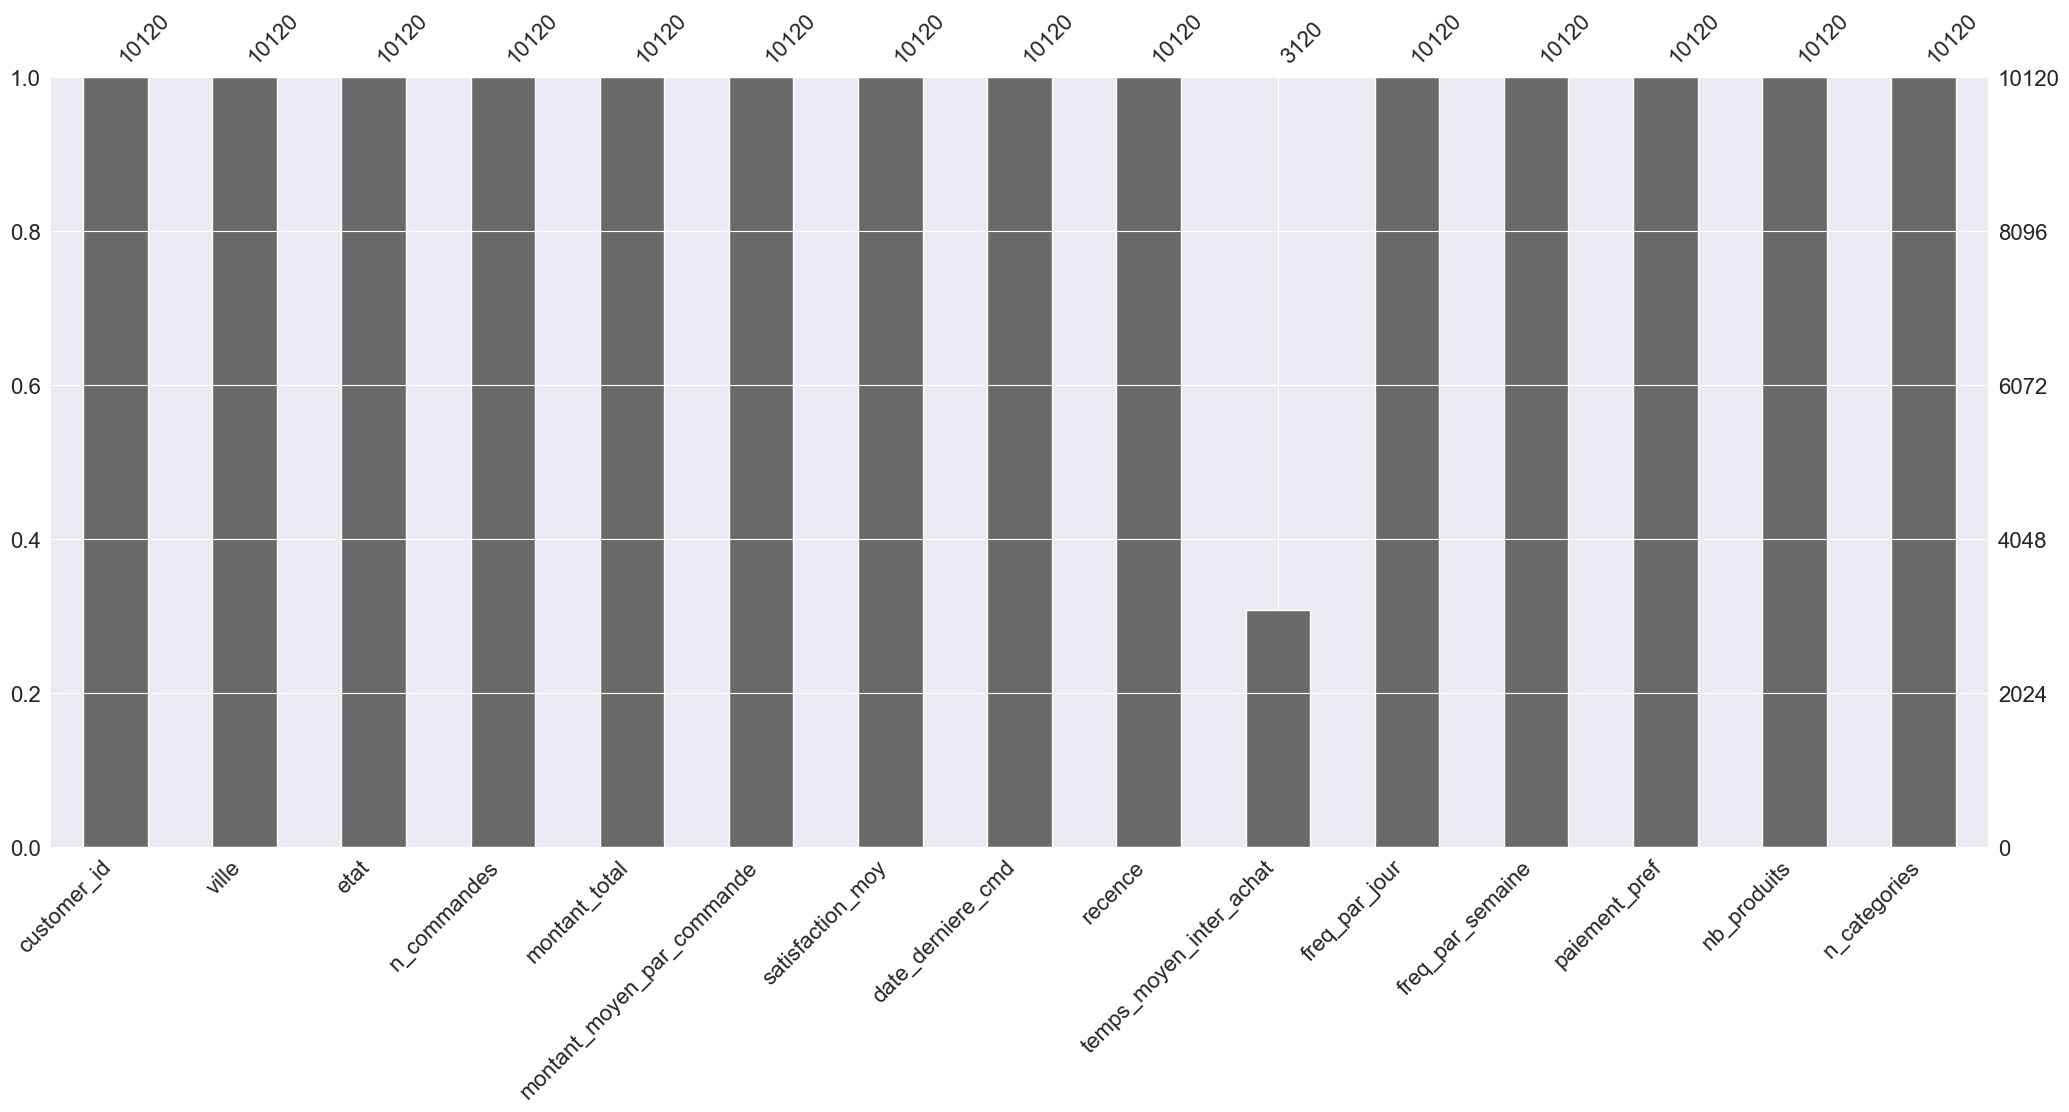

In [6]:
msno.bar(df_clients)

,Taux de valeurs manquantes (%)
temps_moyen_inter_achat,69.16996


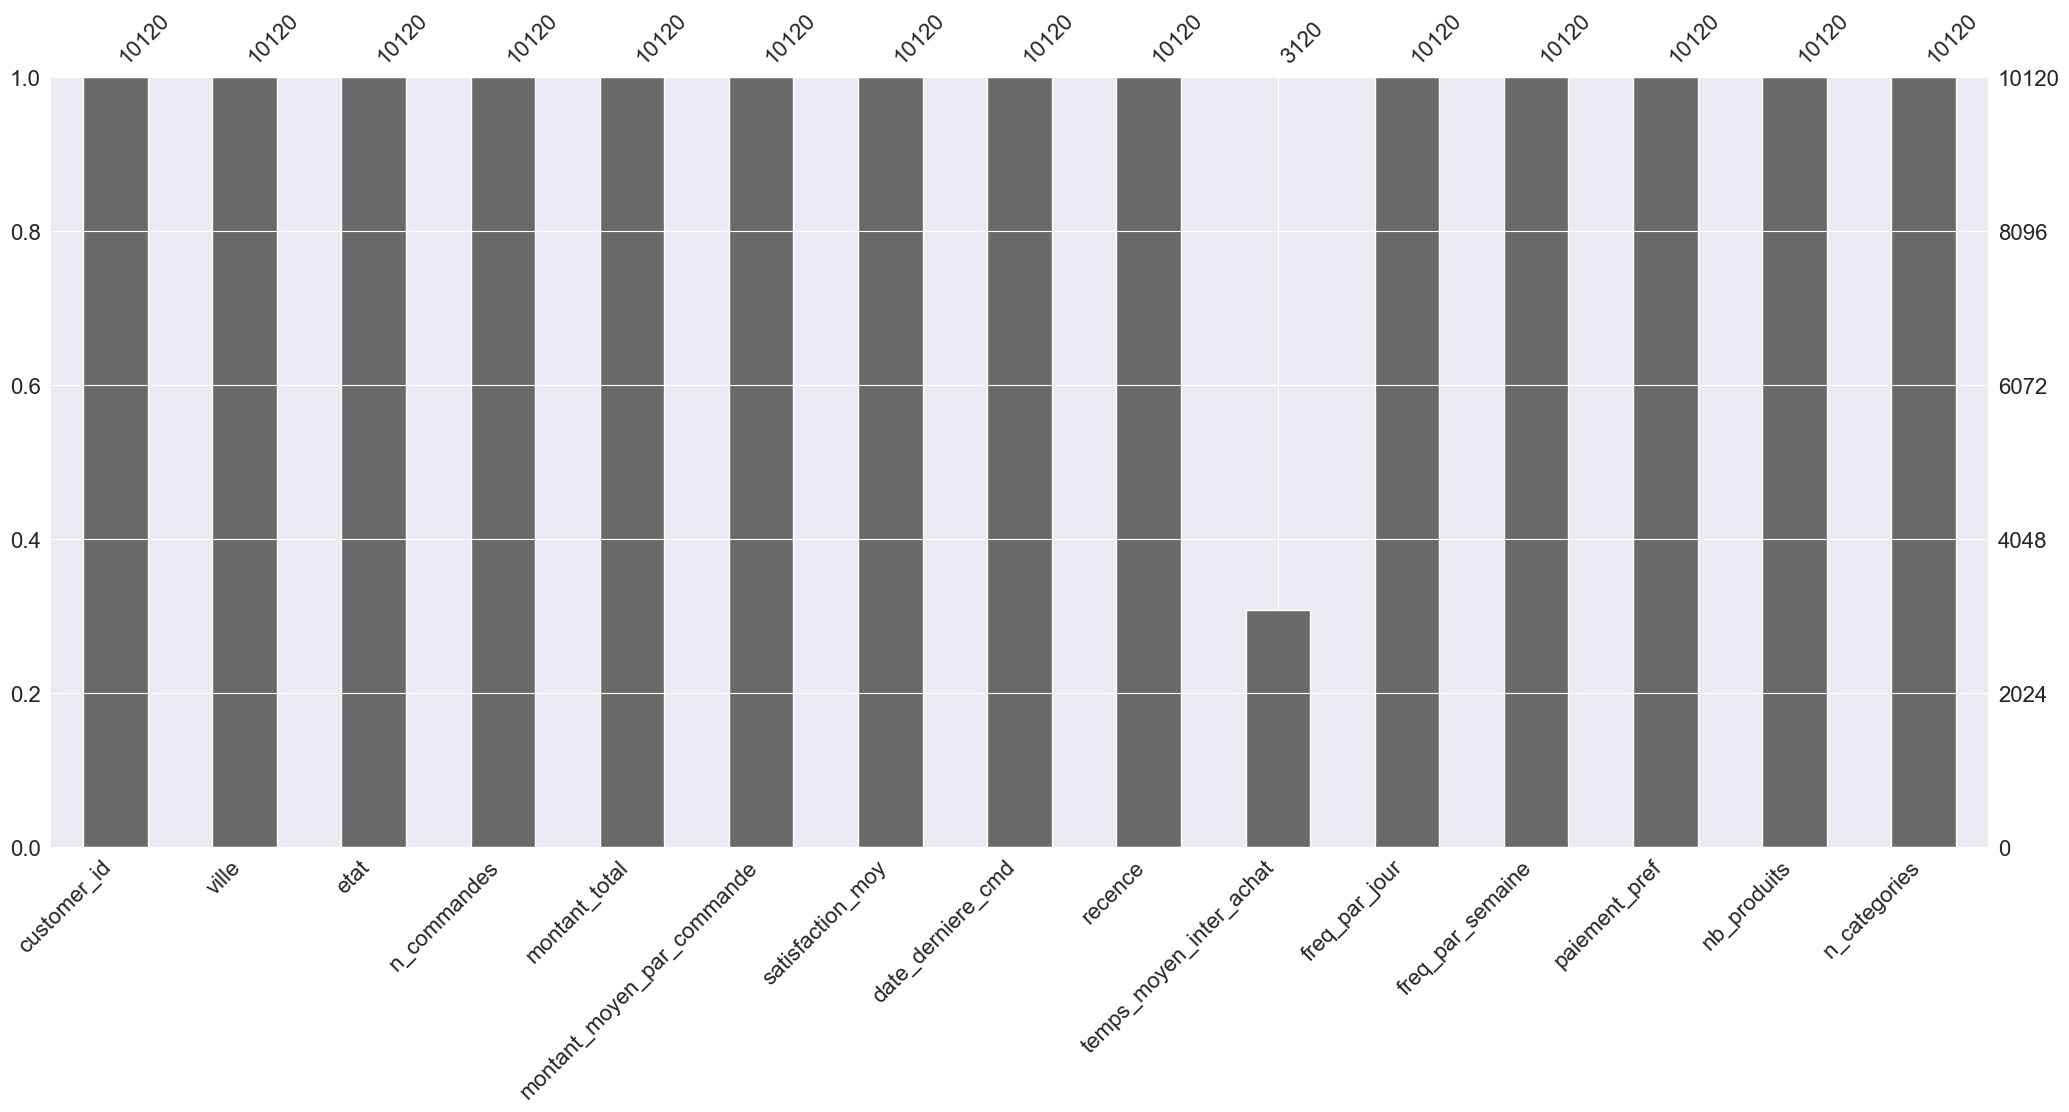

In [7]:
f.afficher_taux_remplissage(df_clients)

In [8]:
df_clients['is_recurrent'] = df_clients['temps_moyen_inter_achat'].notna().astype(int)

In [9]:
df_clients.isna().sum()
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10120 entries, 0 to 10119
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 10120 non-null  object        
 1   ville                       10120 non-null  object        
 2   etat                        10120 non-null  object        
 3   n_commandes                 10120 non-null  int64         
 4   montant_total               10120 non-null  float64       
 5   montant_moyen_par_commande  10120 non-null  float64       
 6   satisfaction_moy            10120 non-null  float64       
 7   date_derniere_cmd           10120 non-null  datetime64[us]
 8   recence                     10120 non-null  int64         
 9   temps_moyen_inter_achat     3120 non-null   float64       
 10  freq_par_jour               10120 non-null  float64       
 11  freq_par_semaine            10120 non-null  float64   

<Axes: >

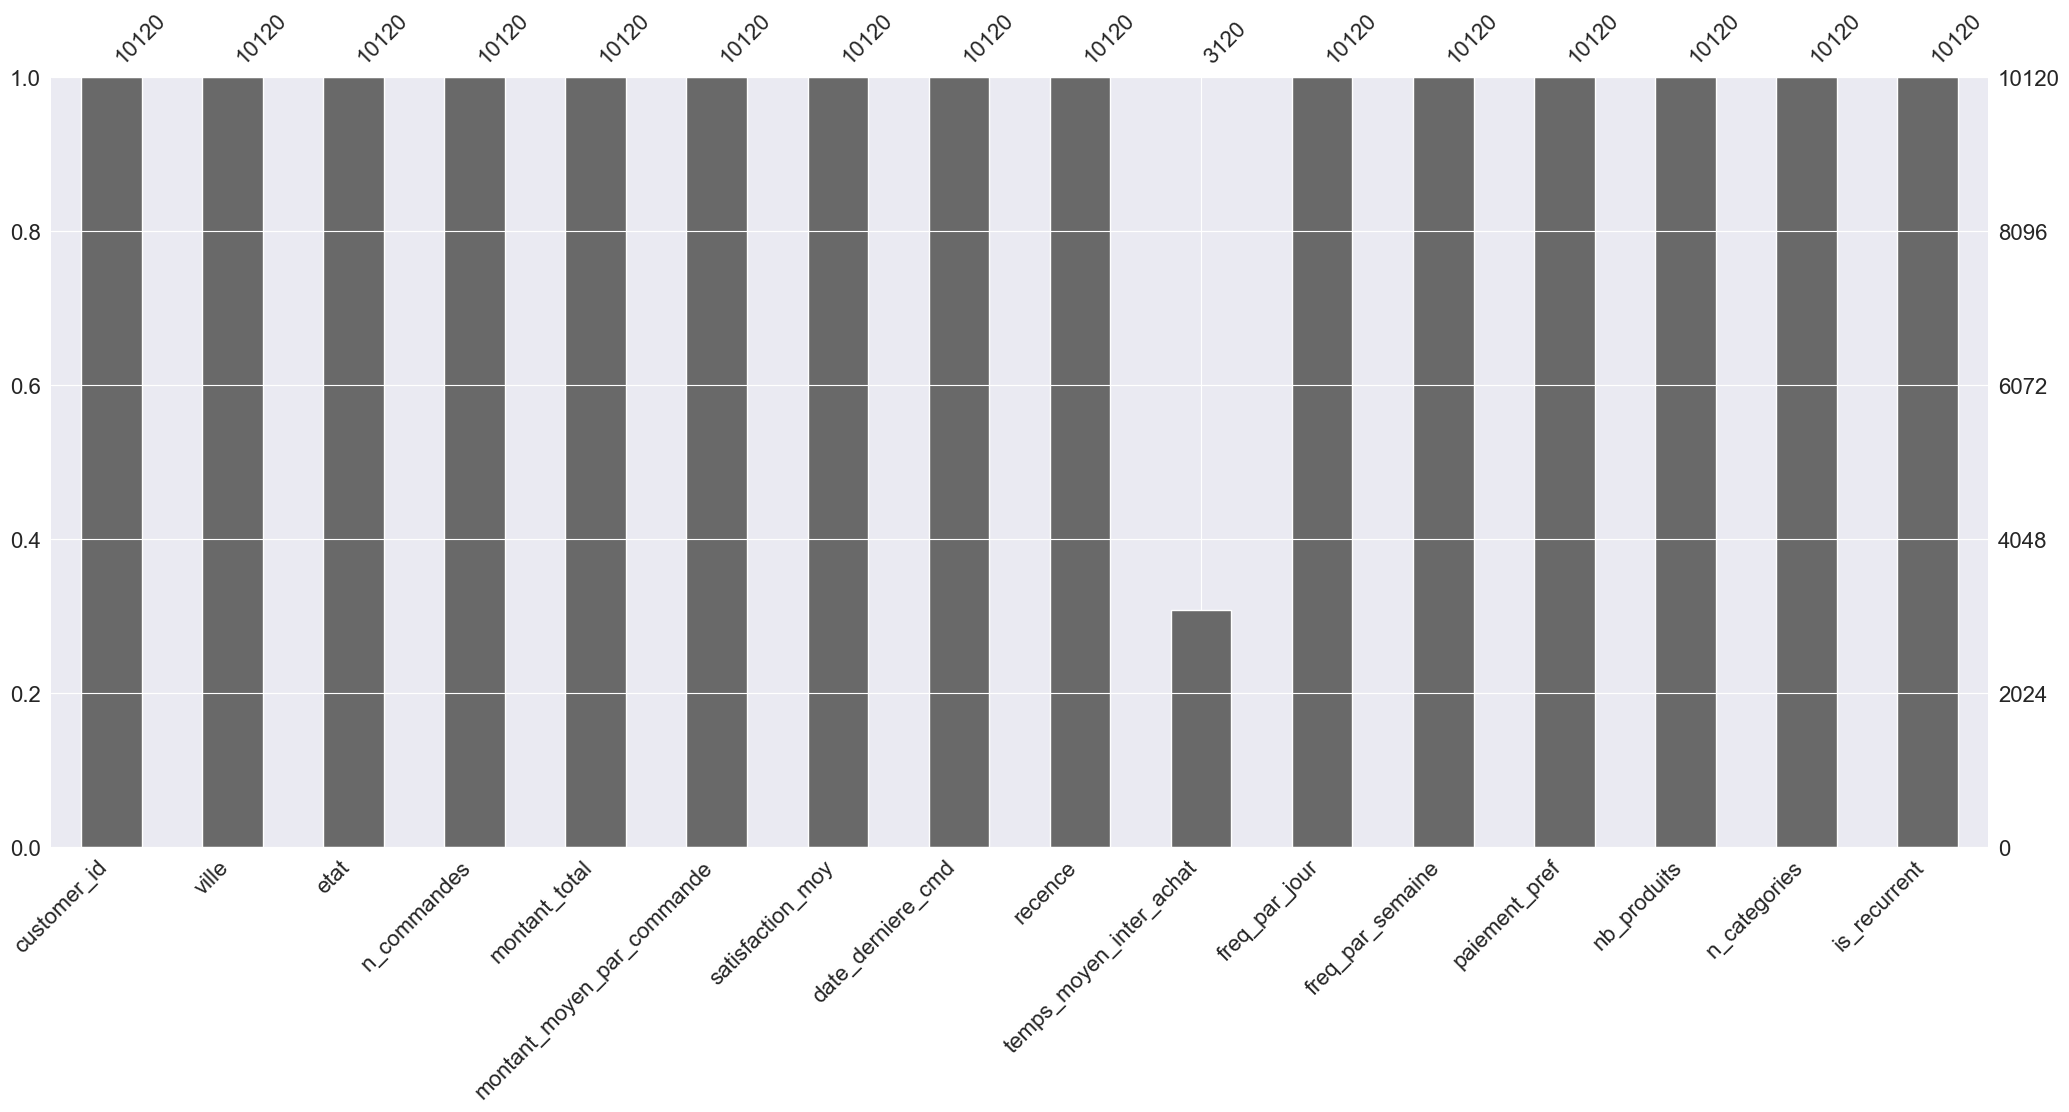

In [10]:
msno.bar(df_clients)

RFM

In [11]:
#rm = df_clients[['customer_id', 'recence', 'montant_total','temps_moyen_inter_achat']].copy()

# Découpage en quartiles (scores de 1 à 4 pour chaque axe)
#rm['R'] = pd.qcut(rm['recence'], 4, labels=[4, 3, 2, 1]).astype(int)  # 4=le plus récent
#rm['F'] = pd.qcut(rm['temps_moyen_inter_achat'], 4, labels=[1, 2, 3, 4]).astype(int)
#rm['M'] = pd.qcut(rm['montant_total'], 4, labels=[1, 2, 3, 4]).astype(int)  # 4=meilleur client/moyen € le plus haut

# Création d'un segment RM
# rm['segment_RFM'] = rm['R'].astype(str) + rm['F'].astype(str) + rm['M'].astype(str)

# Affiche un aperçu des résultats
# rm.head()

In [12]:
# Les meilleurs clients
# rm[rm['segment_RFM'] == rm['segment_RFM'].max()].head()

In [13]:
# df_clients = pd.merge(df_clients, rm[['customer_id', 'segment_RFM', 'R', 'F', 'M']], on='customer_id')

In [14]:
# msno.bar(df_clients)

Stats descriptives

In [15]:
df_clients.describe()

,n_commandes,montant_total,montant_moyen_par_commande,satisfaction_moy,date_derniere_cmd,recence,temps_moyen_inter_achat,freq_par_jour,freq_par_semaine,nb_produits,n_categories,is_recurrent
count,10120.000000,10120.000000,10120.000000,10120.000000,10120,10120.000000,3120.000000,10120.000000,10120.000000,10120.000000,10120.000000,10120.000000
mean,1.344071,464.081665,164.538867,4.068828,2018-01-08 21:24:45.635375,281.739427,82.160945,0.791506,5.540542,1.350692,1.167589,0.308300
min,1.000000,14.290000,14.290000,0.000000,2016-10-03 16:56:50,1.000000,0.000000,0.001642,0.011494,0.000000,0.000000,0.000000
25%,1.000000,81.050000,66.670000,3.666667,2017-09-24 20:52:31.750000,160.000000,0.000000,1.000000,7.000000,1.000000,1.000000,0.000000
50%,1.000000,172.520000,111.790000,5.000000,2018-01-29 16:09:01.500000,261.000000,33.000000,1.000000,7.000000,1.000000,1.000000,0.000000
75%,2.000000,419.105000,183.898750,5.000000,2018-05-10 14:03:33.250000,388.000000,127.000000,1.000000,7.000000,2.000000,1.000000,1.000000
max,17.000000,111741.840000,4445.500000,5.000000,2018-10-16 20:16:02,744.000000,609.000000,3.000000,21.000000,15.000000,5.000000,1.000000
std,0.588450,1708.469864,212.759404,1.321816,NaN,151.615647,109.400876,0.398747,2.791228,0.687614,0.453573,0.461814


In [16]:
df_analyse = df_clients.drop('customer_id', axis=1)
f.full_describe(df_analyse)['quantitatives']

,count,mean,median,std,min,max,skew,kurt
n_commandes,10120.0,1.344071,1.00,0.588450,1.000000,17.00,3.838470,58.563103
montant_total,10120.0,464.081665,172.52,1708.469864,14.290000,111741.84,34.809574,1928.795067
montant_moyen_par_commande,10120.0,164.538867,111.79,212.759404,14.290000,4445.50,6.965607,83.450984
satisfaction_moy,10120.0,4.068828,5.00,1.321816,0.000000,5.00,-1.358163,0.645149
recence,10120.0,281.739427,261.00,151.615647,1.000000,744.00,0.475043,-0.606344
temps_moyen_inter_achat,3120.0,82.160945,33.00,109.400876,0.000000,609.00,1.658499,2.424836
freq_par_jour,10120.0,0.791506,1.00,0.398747,0.001642,3.00,-1.343157,0.118643
freq_par_semaine,10120.0,5.540542,7.00,2.791228,0.011494,21.00,-1.343157,0.118643
nb_produits,10120.0,1.350692,1.00,0.687614,0.000000,15.00,3.551350,33.352787
n_categories,10120.0,1.167589,1.00,0.453573,0.000000,5.00,1.965706,6.772378


In [17]:
f.full_describe(df_analyse)['catégorielles']

,count,n_unique,mode,freq_mode (%),top1,freq_top1 (%),top2,freq_top2 (%),top3,freq_top3 (%)
ville,10120,1642,sao paulo,15.74,sao paulo,15.74,rio de janeiro,7.01,belo horizonte,2.91
etat,10120,27,SP,41.94,SP,41.94,RJ,13.07,MG,11.61
paiement_pref,10120,4,credit_card,75.66,credit_card,75.66,boleto,19.49,voucher,3.33


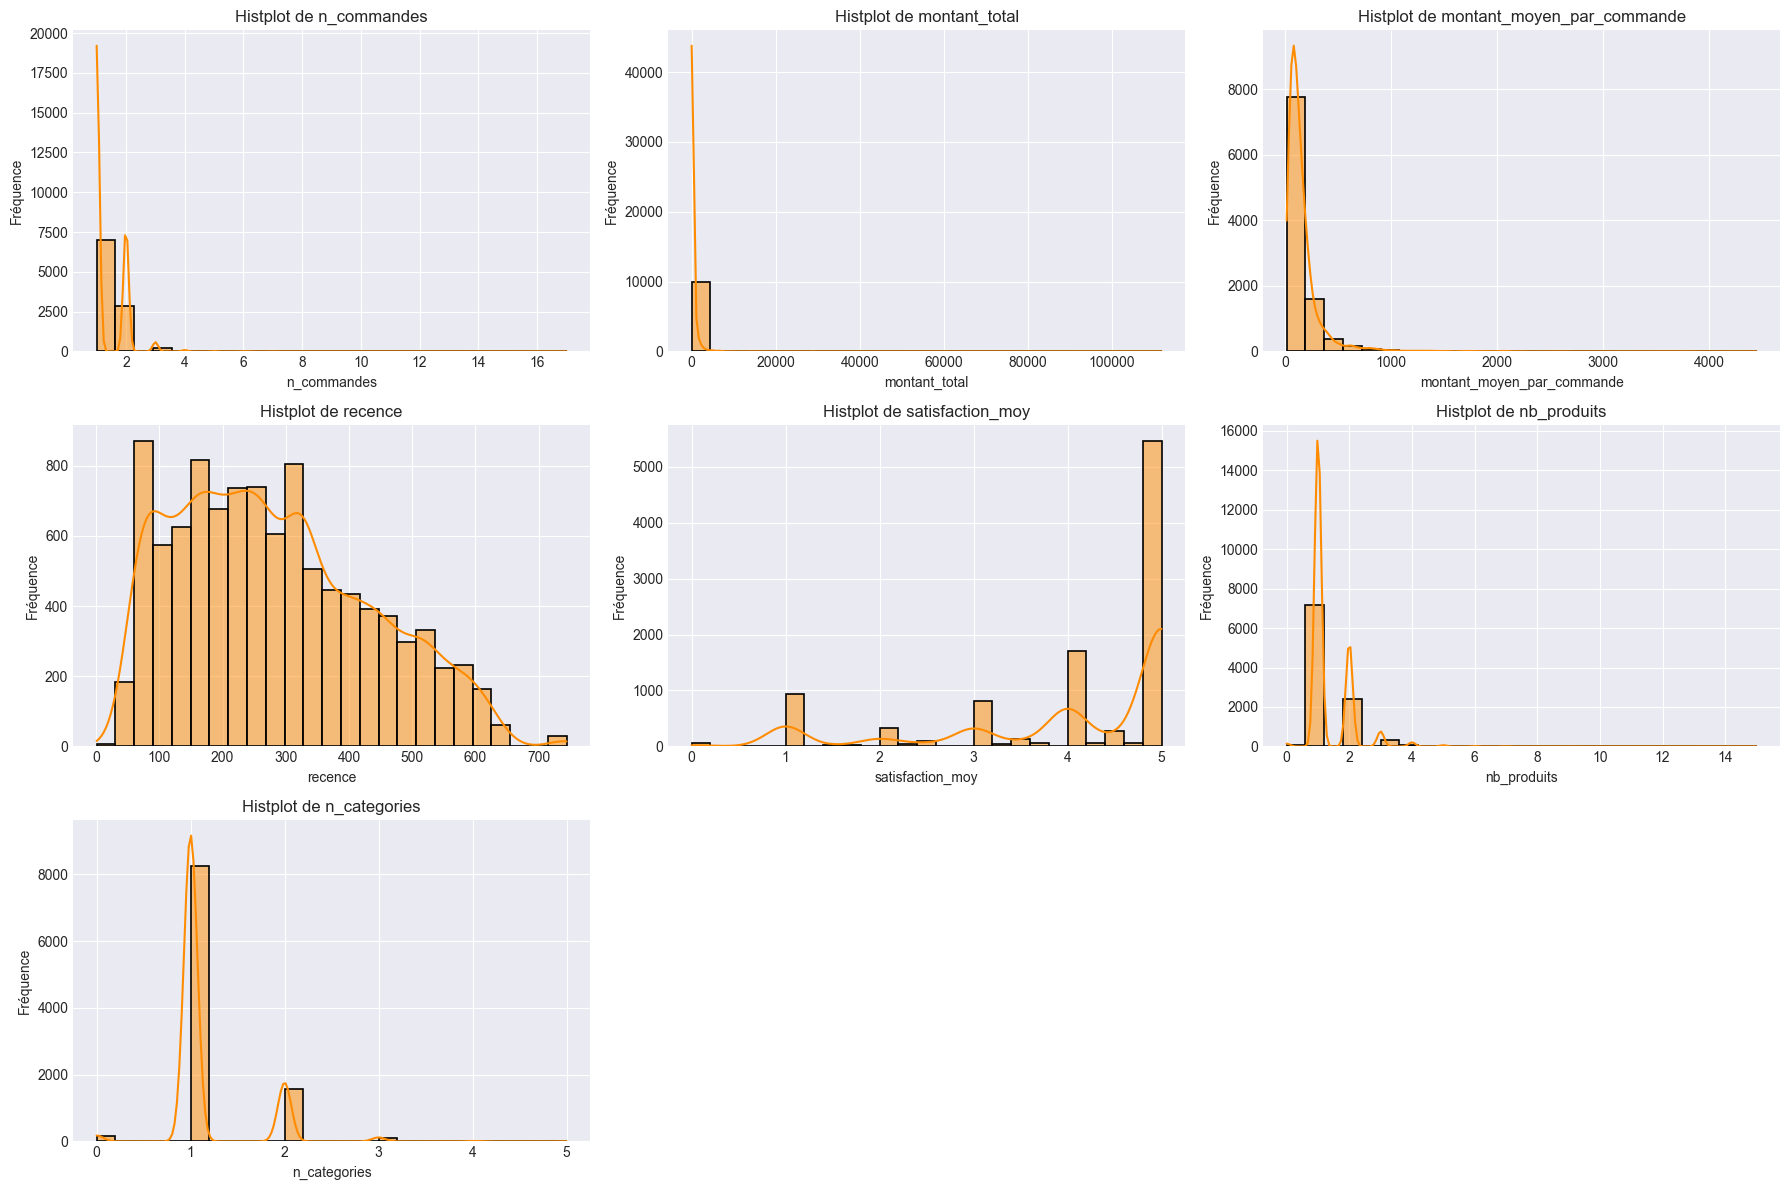

In [18]:
colonnes_num = [
    'n_commandes',
    'montant_total',
    'montant_moyen_par_commande',
    'recence',
    'satisfaction_moy',
    'nb_produits',
    'n_categories'
]


# Histogrammes
f.graphiques(df_clients, colonnes=colonnes_num, plot_type="histplot", ncols=3, bins=25)

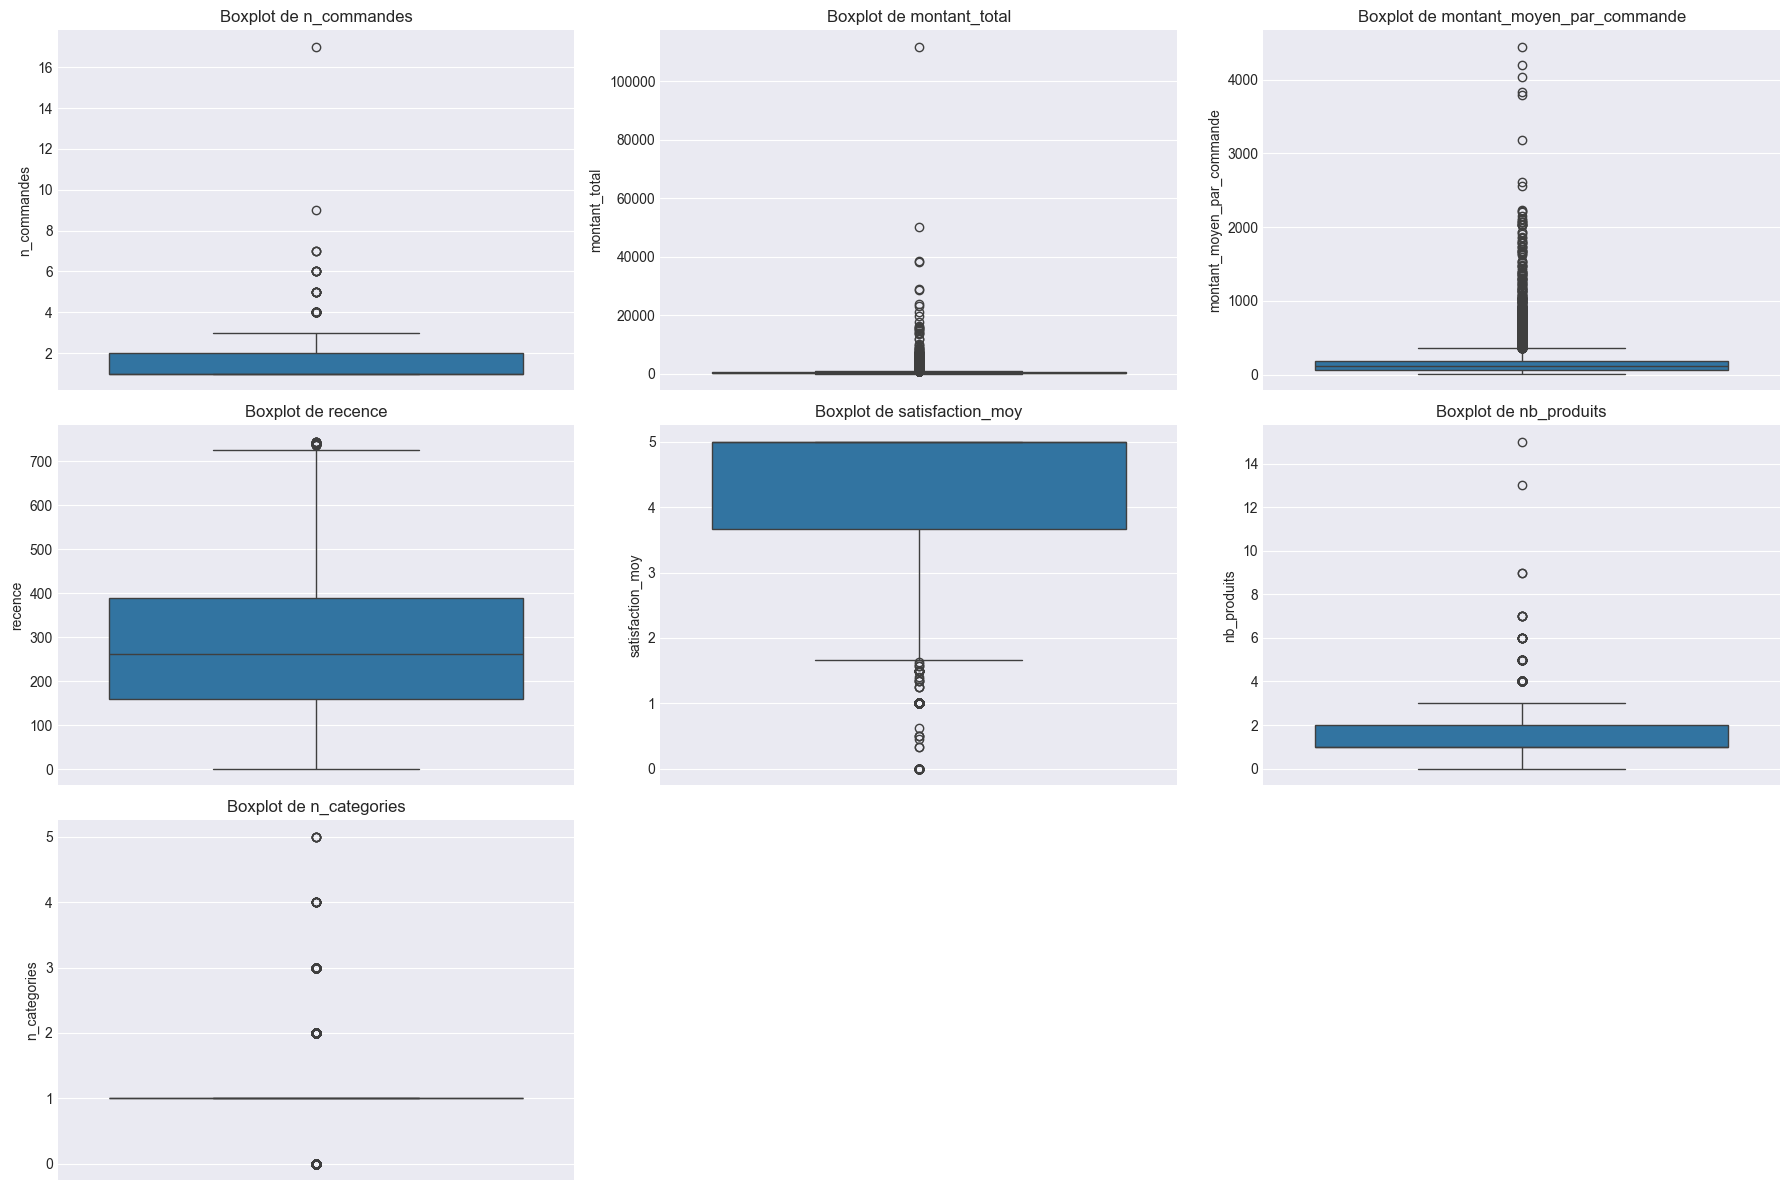

In [19]:
# Histogrammes
f.graphiques(df_clients, colonnes=colonnes_num, plot_type="boxplot", ncols=3, bins=25)

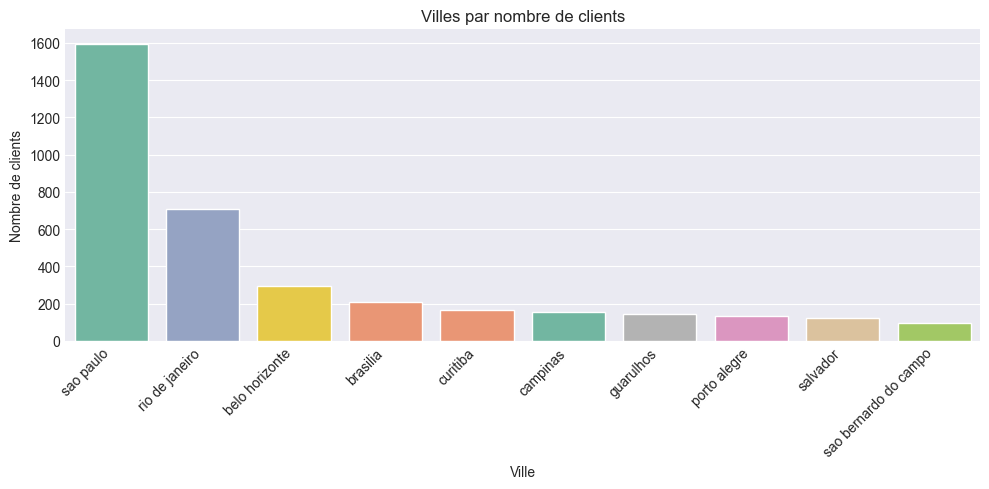

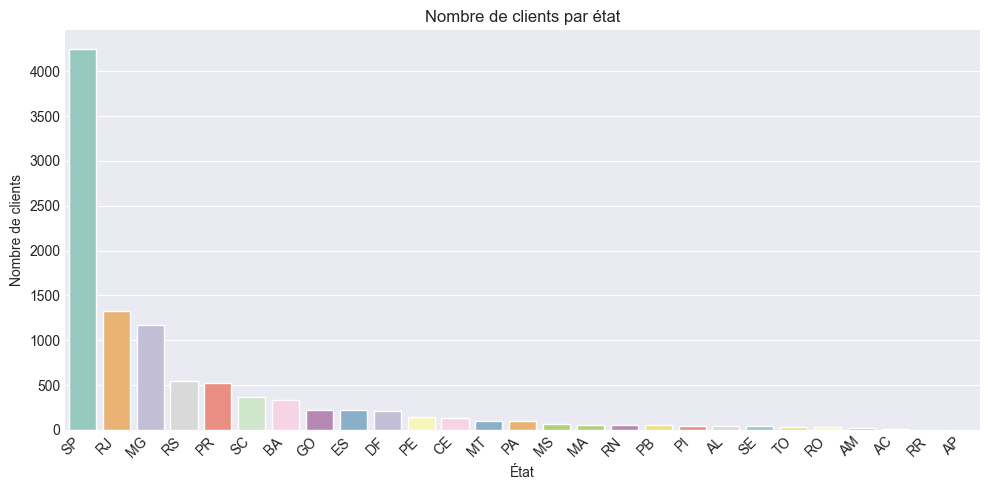

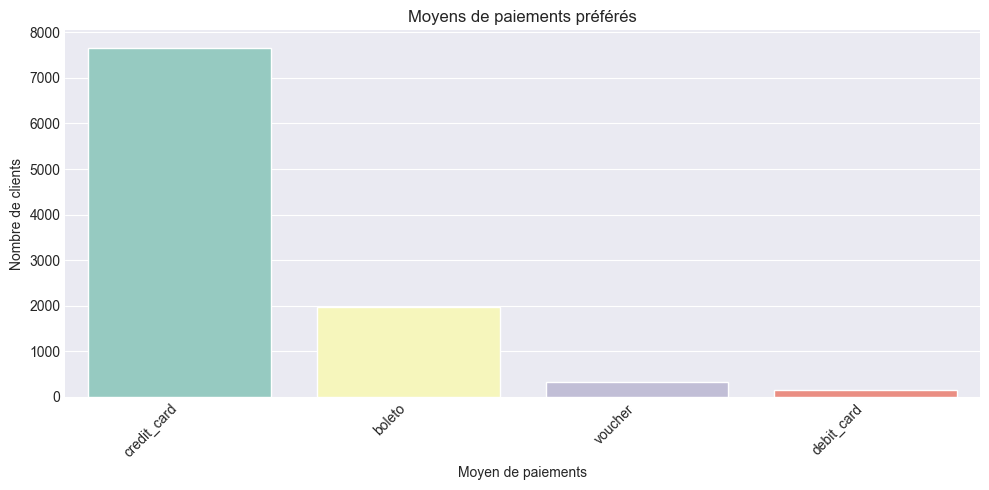

In [20]:
# Countplot pour les villes
top_villes = df_clients['ville'].value_counts().head(10).index

plt.figure(figsize=(10,5))
sns.countplot(data=df_clients[df_clients['ville'].isin(top_villes)],x='ville',order=top_villes,palette='Set2', hue='ville', legend=False)
plt.title('Villes par nombre de clients')
plt.xlabel('Ville')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Countplot pour les états
plt.figure(figsize=(10,5))
sns.countplot(data=df_clients, x='etat', order=df_clients['etat'].value_counts().index, palette='Set3', hue='etat', legend=False)
plt.title('Nombre de clients par état')
plt.xlabel('État')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Countplot pour les moyens de paiement
plt.figure(figsize=(10,5))
sns.countplot(data=df_clients, x='paiement_pref', order=df_clients['paiement_pref'].value_counts().index, palette='Set3', hue='paiement_pref', legend=False)
plt.title('Moyens de paiements préférés')
plt.xlabel('Moyen de paiements')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Relations entre les variables

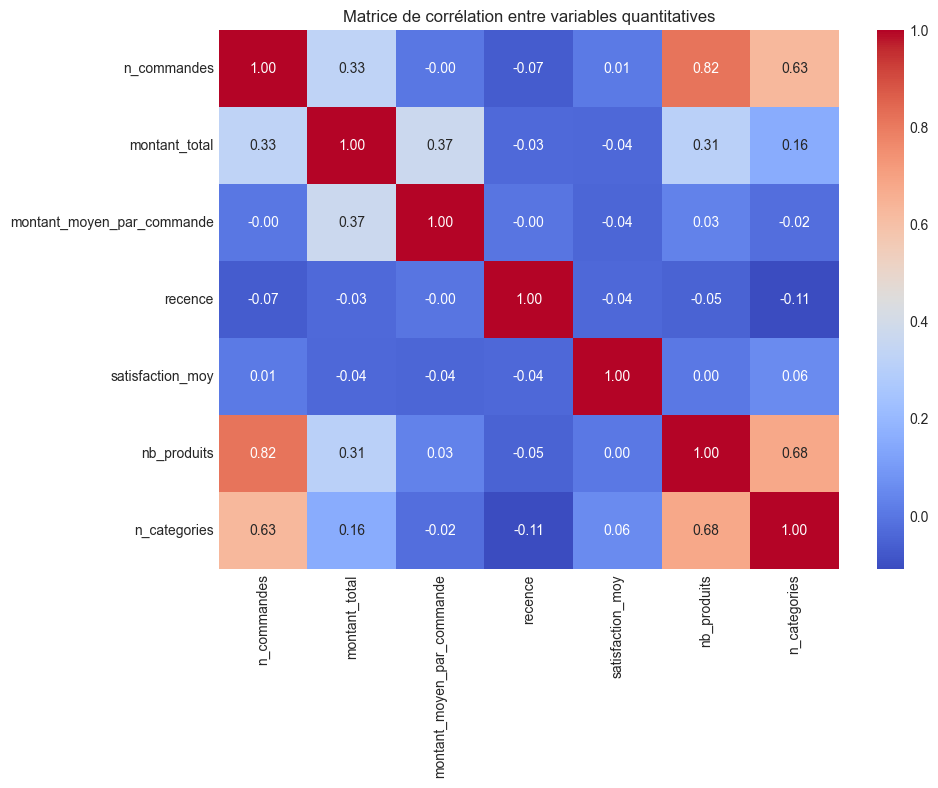

In [21]:
# Matrice de corrélation
plt.figure(figsize=(10, 7))
sns.heatmap(df_clients[colonnes_num].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation entre variables quantitatives')
plt.show()

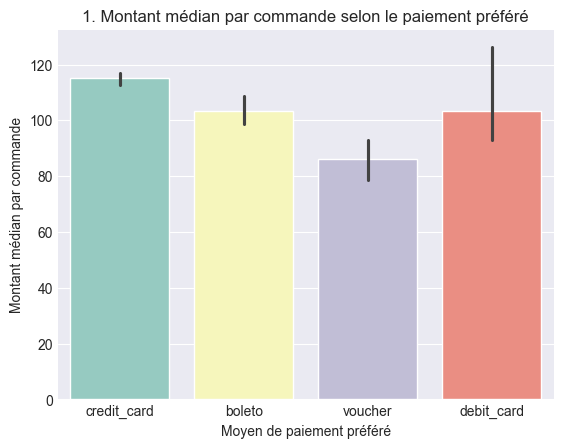

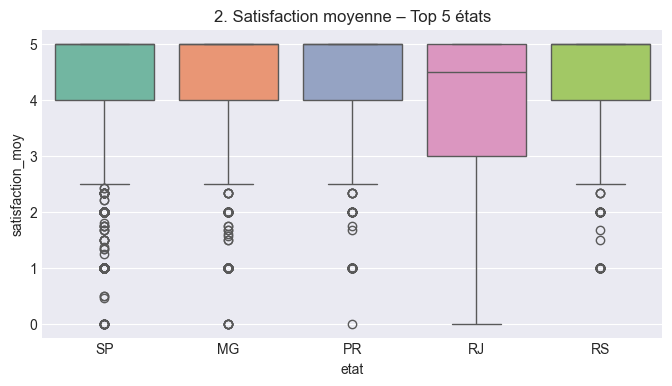

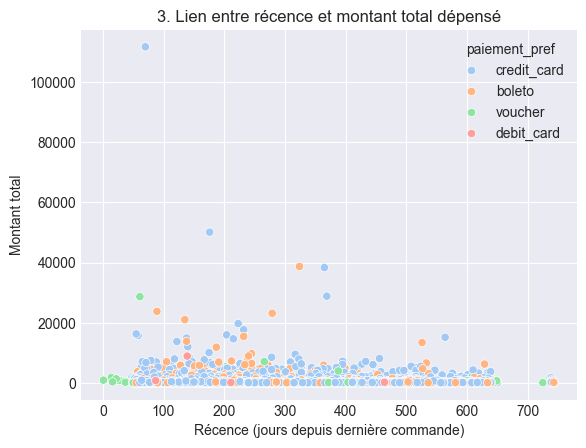

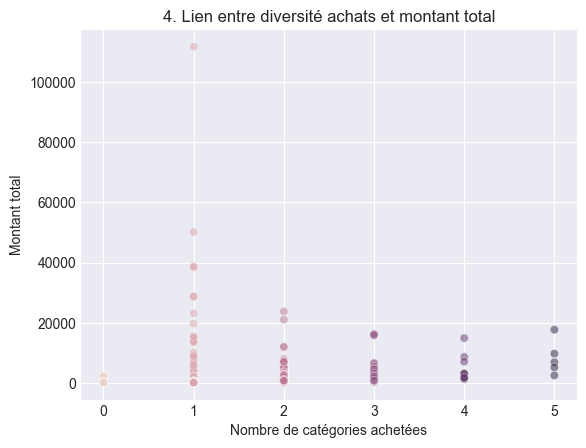

In [22]:
# Visualisations

# 1. Montant médian par commande selon le paiement préféré
sns.barplot(data=df_clients,x='paiement_pref',y='montant_moyen_par_commande',estimator=np.median,palette="Set3", hue='paiement_pref', legend=False)
plt.title('1. Montant médian par commande selon le paiement préféré')
plt.ylabel('Montant médian par commande')
plt.xlabel('Moyen de paiement préféré')
plt.show()

# 2. Satisfaction moyenne – Top 5 états
top_etats = df_clients['etat'].value_counts().head(5).index
df_top_etats = df_clients[df_clients['etat'].isin(top_etats)]

plt.figure(figsize=(8,4))
sns.boxplot(data=df_top_etats, x='etat', y='satisfaction_moy', palette='Set2', hue='etat', legend=False)
plt.title('2. Satisfaction moyenne – Top 5 états')
plt.show()

# 3. Lien entre récence et montant total dépensé
sns.scatterplot(data=df_clients, x='recence', y='montant_total', hue='paiement_pref', palette='pastel')
plt.title('3. Lien entre récence et montant total dépensé')
plt.xlabel('Récence (jours depuis dernière commande)')
plt.ylabel('Montant total')
plt.show()

# 4. Lien entre diversité achats et montant total
sns.scatterplot(data=df_clients, x='n_categories', y='montant_total', alpha=0.5, hue='n_categories', legend=False)
plt.title('4. Lien entre diversité achats et montant total')
plt.xlabel('Nombre de catégories achetées')
plt.ylabel('Montant total')
plt.show()

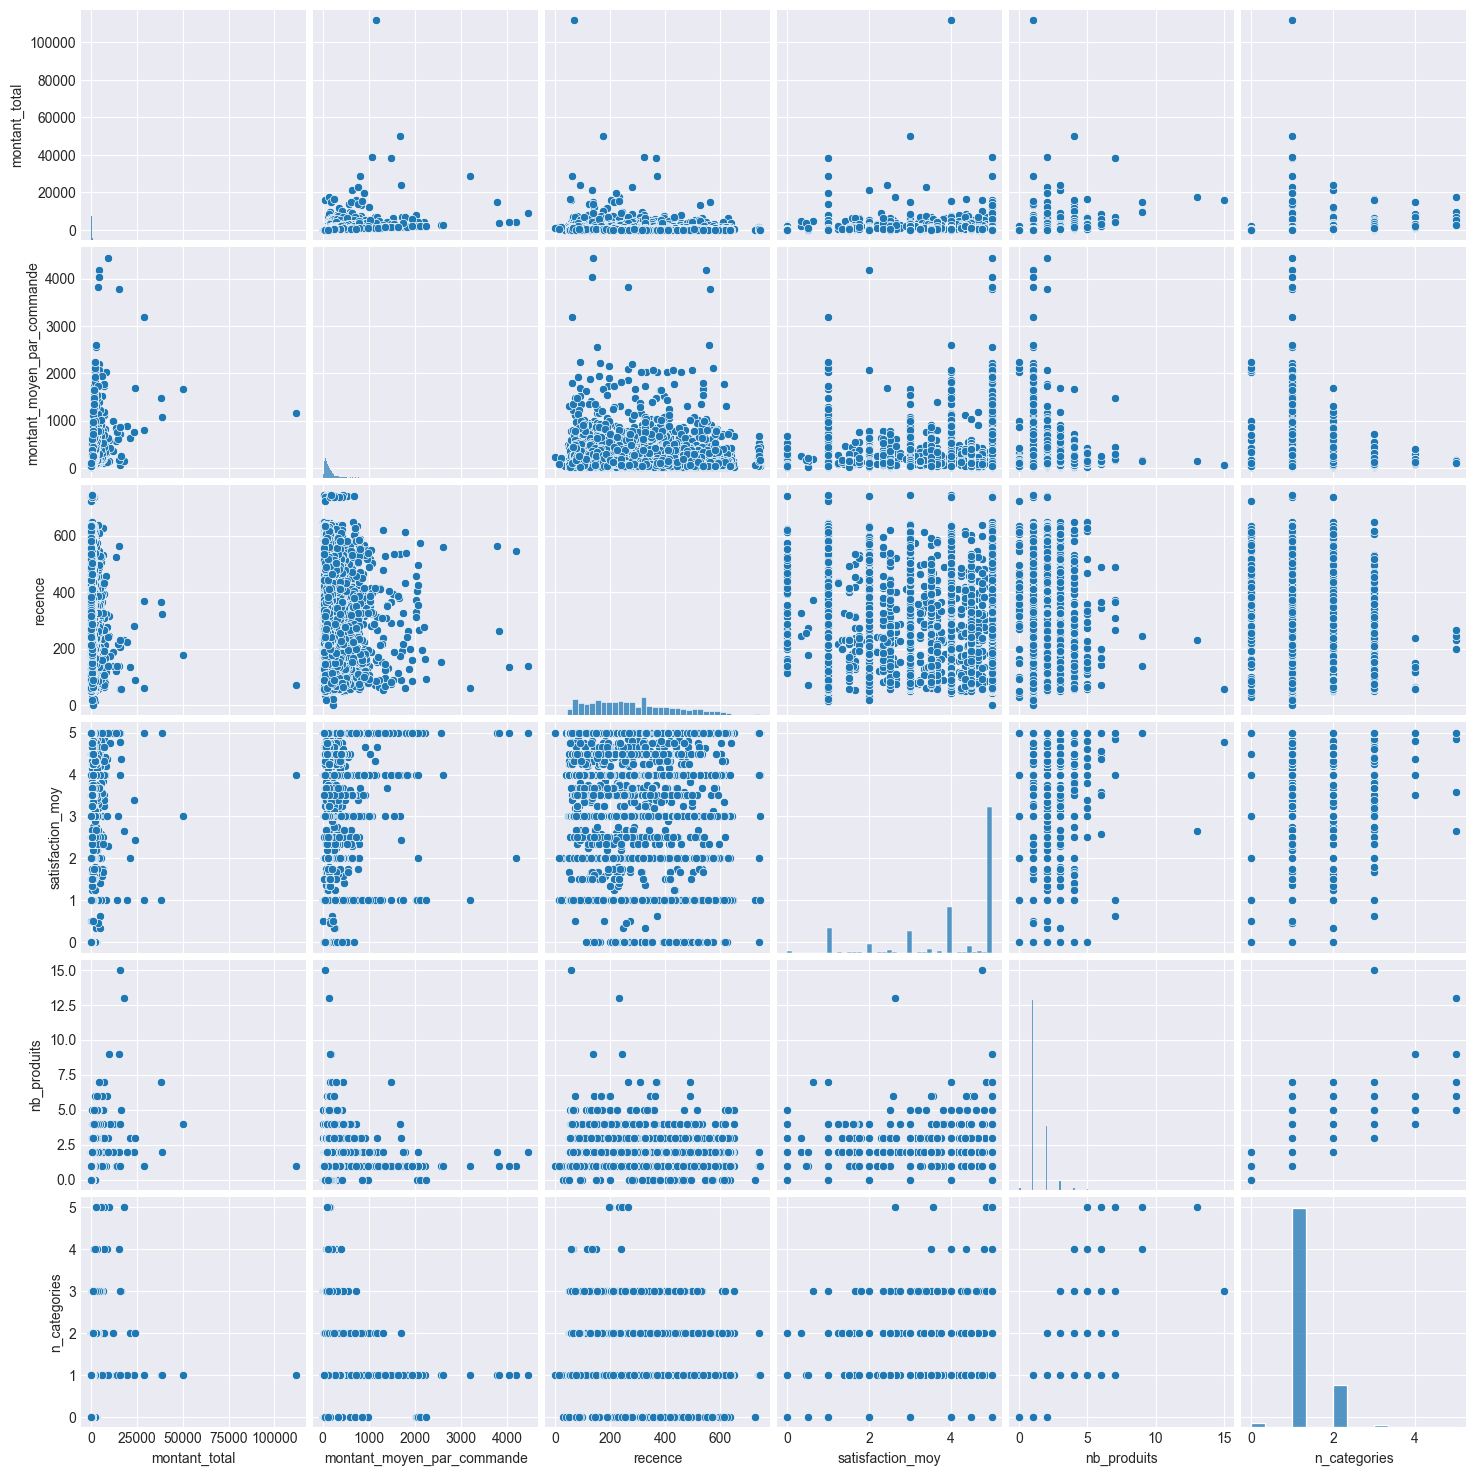

In [23]:
sns.pairplot(df_clients[[
    'montant_total', 'montant_moyen_par_commande', 'recence',
    'satisfaction_moy', 'nb_produits', 'n_categories'
]])
plt.show()

In [24]:
df_clients.columns

Index(['customer_id', 'ville', 'etat', 'n_commandes', 'montant_total',
       'montant_moyen_par_commande', 'satisfaction_moy', 'date_derniere_cmd',
       'recence', 'temps_moyen_inter_achat', 'freq_par_jour',
       'freq_par_semaine', 'paiement_pref', 'nb_produits', 'n_categories',
       'is_recurrent'],
      dtype='object')

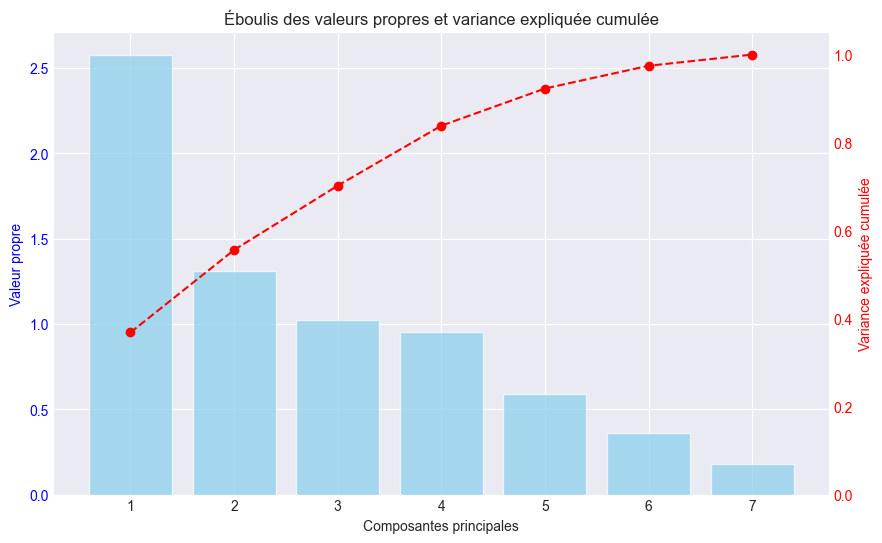

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

colonnes_acp = colonnes_num

# Sélection des colonnes numériques
X = df_clients[colonnes_acp].dropna()

# 1. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. ACP
acp = PCA(n_components=X_scaled.shape[1])
X_acp = acp.fit_transform(X_scaled)

# 3. Valeurs propres et variance expliquée
eigenvalues = acp.explained_variance_
explained_variance_ratio = acp.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# 4. Eboulis (Scree plot)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='skyblue', alpha=0.7)
ax1.set_xlabel("Composantes principales")
ax1.set_ylabel("Valeur propre", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red')
ax2.set_ylabel("Variance expliquée cumulée", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1.05)

plt.title("Éboulis des valeurs propres et variance expliquée cumulée")
plt.grid()
plt.show()

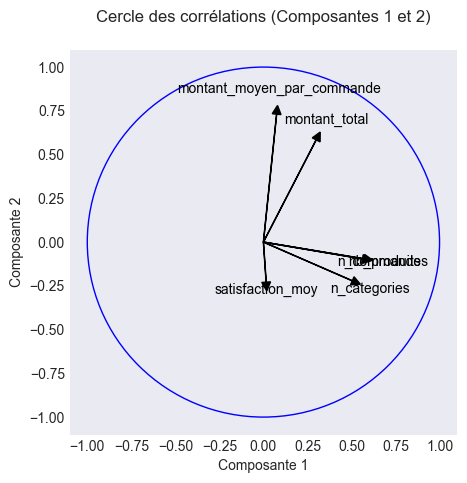

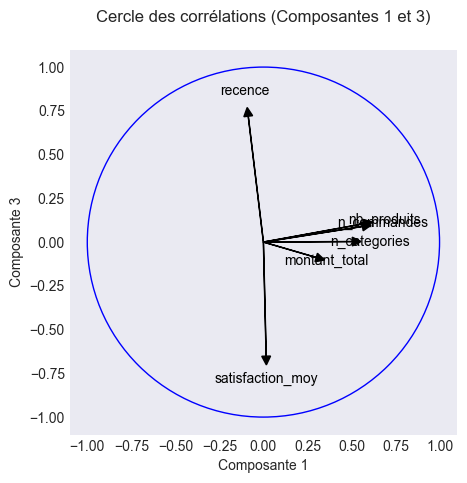

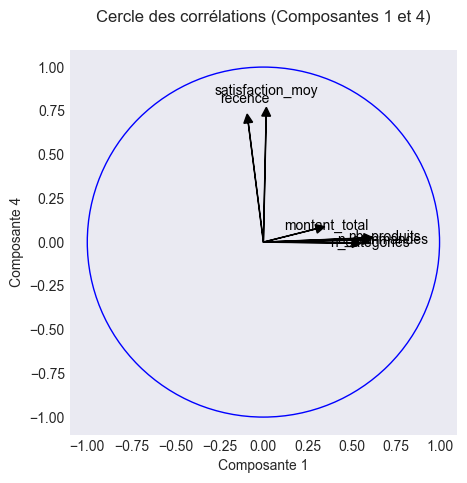

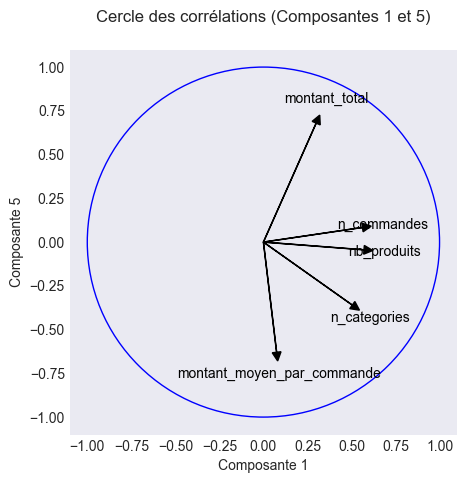

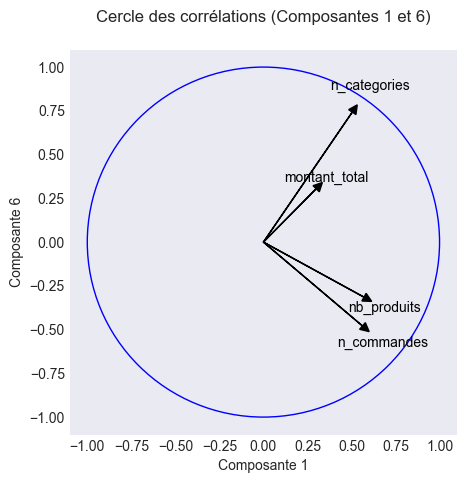

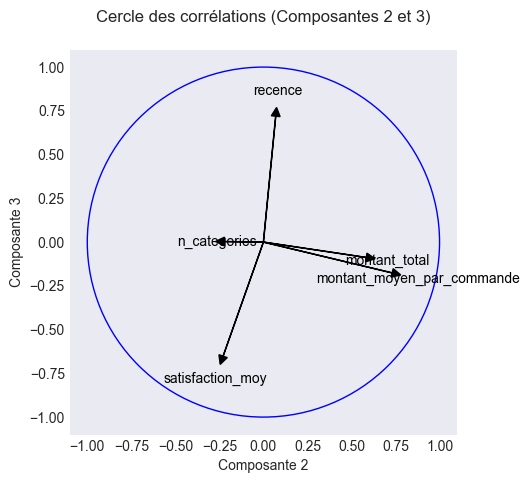

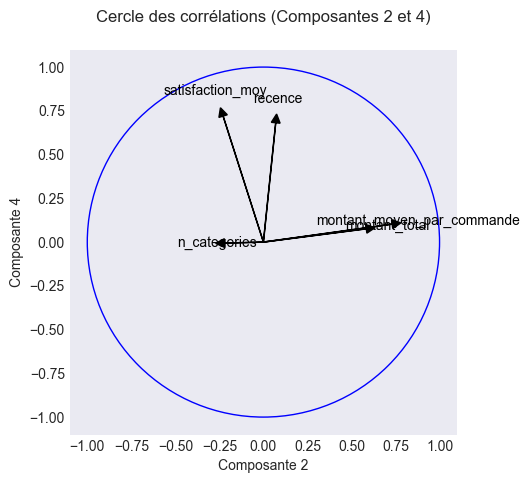

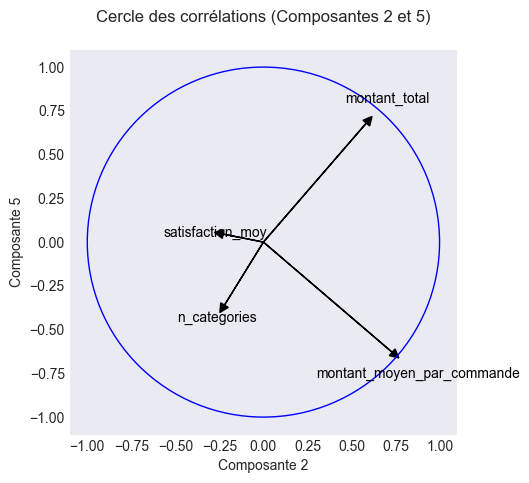

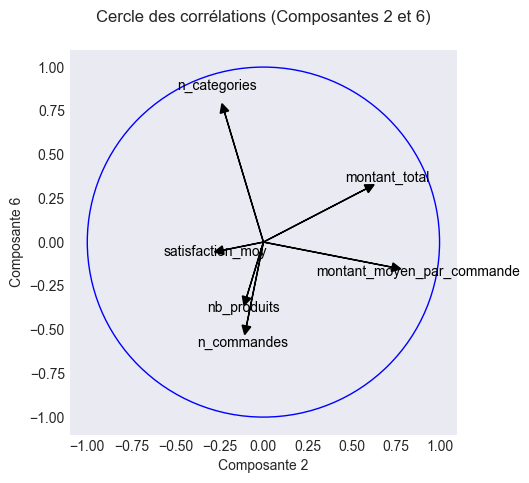

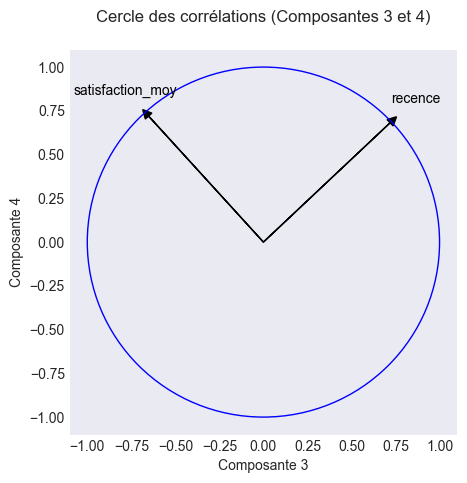

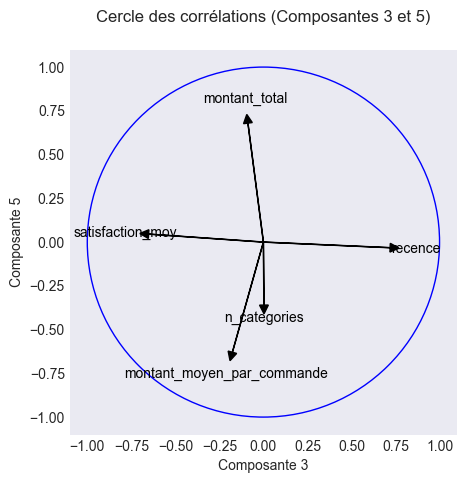

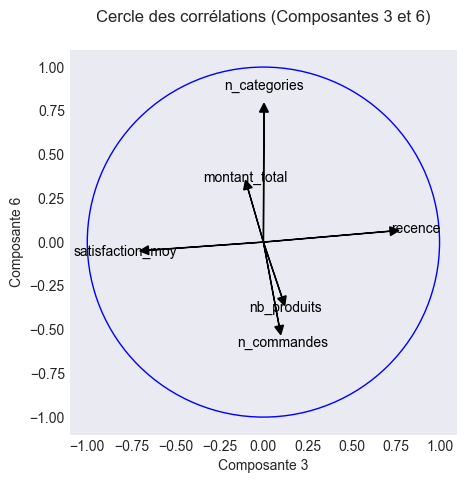

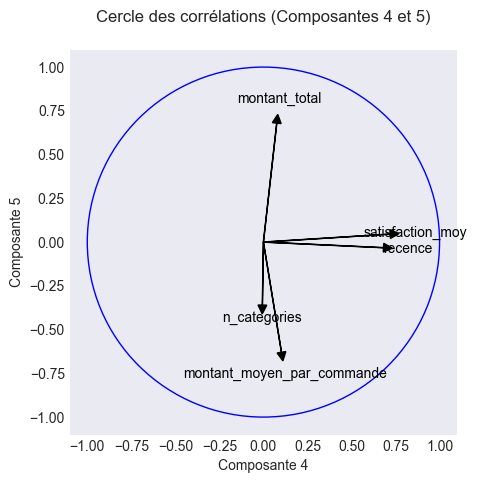

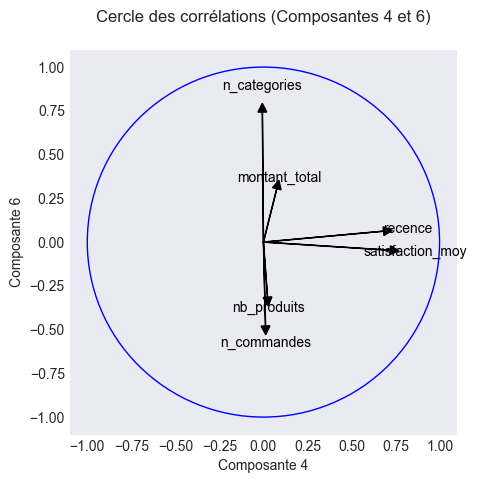

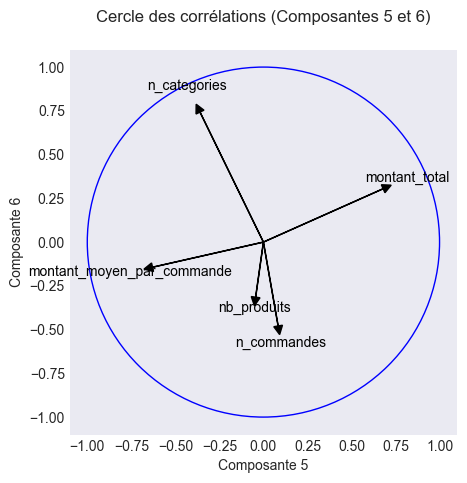

In [26]:
for axis1 in range(6):
    for axis2 in range(axis1 + 1, 6):
        f.cercle_correlations(acp, colonnes_acp, axis1, axis2)

In [27]:
composantes_acp = pd.DataFrame(acp.components_, columns=df_clients[colonnes_acp].columns, index=[f'PC{i+1}' for i in range(X_acp.shape[1])])
composantes_acp.head()

,n_commandes,montant_total,montant_moyen_par_commande,recence,satisfaction_moy,nb_produits,n_categories
PC1,0.562402,0.299580,0.074993,-0.086133,0.015581,0.571005,0.504603
PC2,-0.096322,0.584124,0.730944,0.069848,-0.228847,-0.095415,-0.221107
PC3,0.089270,-0.087952,-0.176134,0.719323,-0.651780,0.104977,0.003016
PC4,0.011979,0.075793,0.102528,0.681781,0.719861,0.023275,-0.005776
PC5,0.083511,0.679760,-0.629523,-0.032090,0.045633,-0.044177,-0.359984


L’analyse des contributions des variables aux axes principaux montre que:

- L’axe 1 (PC1) est porté principalement par les **variables financières** («montant total» et «montant moyen par commande»)
- L’axe 2 caractérise la **diversité des achats** («nombre de produits», «nombre de catégories»)
- L’axe 3 **oppose** les **clients récents et insatisfaits** aux **clients moins récents mais plus satisfaits**
- L’axe 5 **oppose** la **variété** (catégories couvertes) au **volume** (nombre de produits)

In [28]:
df_clients.columns

Index(['customer_id', 'ville', 'etat', 'n_commandes', 'montant_total',
       'montant_moyen_par_commande', 'satisfaction_moy', 'date_derniere_cmd',
       'recence', 'temps_moyen_inter_achat', 'freq_par_jour',
       'freq_par_semaine', 'paiement_pref', 'nb_produits', 'n_categories',
       'is_recurrent'],
      dtype='object')

In [29]:
df_clients.drop(
    ['customer_id',
     'montant_moyen_par_commande',
     'freq_par_jour',],
    axis=1,
    inplace=True
)

In [30]:
df_clients.to_csv('DATA/clients.csv')

<Axes: >

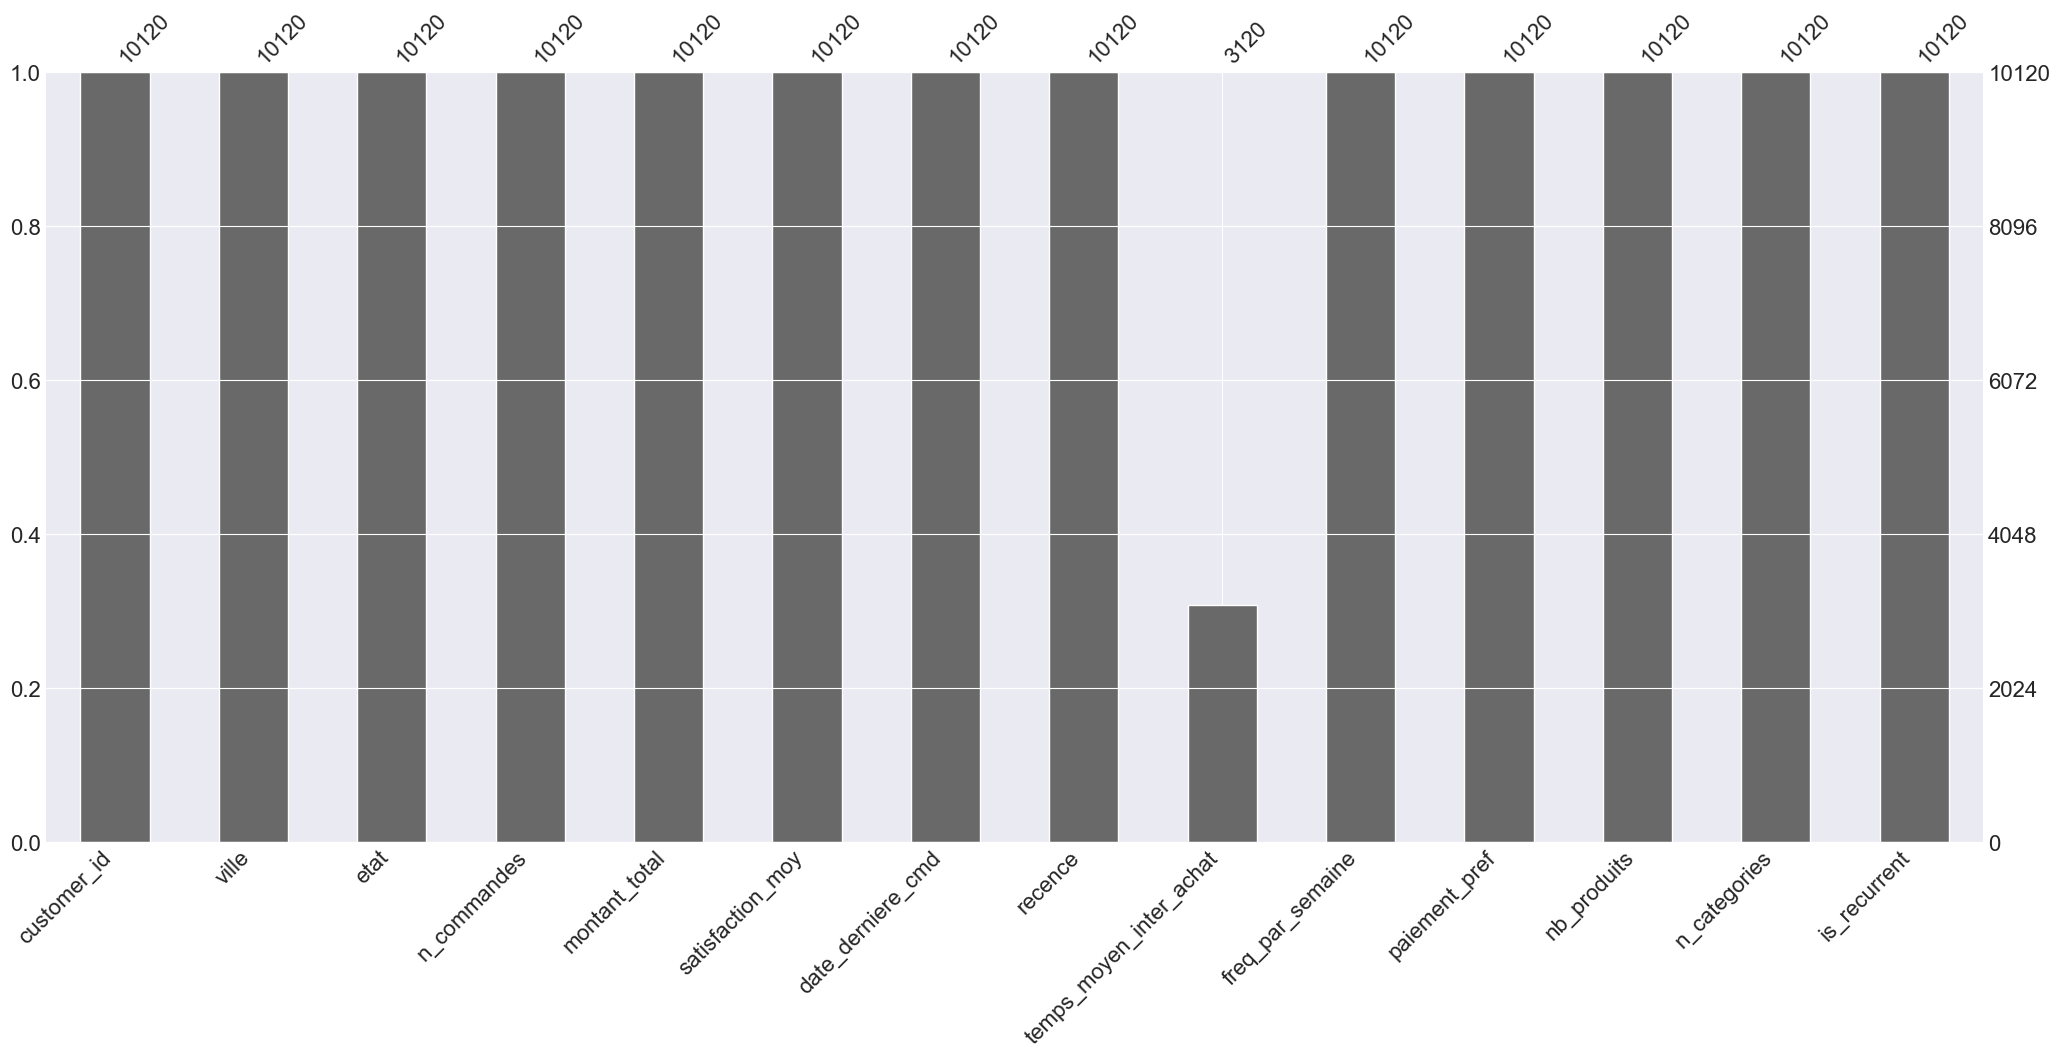

In [31]:
msno.bar(df_clients)